In [1]:
import getpass
import os

In [2]:
if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("llama3-8b-8192", model_provider="groq")

Enter API key for Groq:  ········


## Selecting embeddings.

Let's choose HuggingFace embeddigs

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

Following guide, let's load an article from the Web.

The article is here: https://lilianweng.github.io/posts/2023-06-23-agent/

In [5]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43130


In [6]:
print(docs[0].page_content[:500]) # previewing...



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


For generic use-case, let's apply RecursiveCharacterTextSplitter

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [8]:
# and now we store splits in our in-mem store

document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['82b9053b-e3da-4f62-b93a-004d608353cb', '911f1ed9-bbbc-4eac-aae1-68122bcaaeb2', '03791166-f49e-4b4f-9c55-068091687b42']


## Retrieval

Let's grab the prompt from the langchain

In [9]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

C:\Users\7mull\workspace\dyi-rag\.venv\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


We'll utilize lang-graph for this RAG-model.
Although, it's not necessary to use it, it comes with the benefits and options when we want to get more from our model.

To use LangGraph, we need to define three things:

    - The state of our application;
    - The nodes of our application (i.e., application steps);
    - The "control flow" of our application (e.g., the ordering of the steps).

State:

The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [10]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

**Nodes**

Let's start with a simple sequence of two steps: retrieval and generation.

In [11]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

**Control flow**

Finally, we compile our application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [12]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

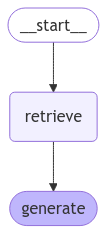

In [13]:
# let's visualize the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
# shall we decide not to use langgraph, we would have to tie those steps together 

def manual_rag(question: str):
    retrieved_docs = vector_store.similarity_search(question)
    docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
    prompt = prompt.invoke({"question": question, "context": docs_content})
    answer = llm.invoke(prompt)

    return answer

In [15]:
# invocation

# invocation might be async
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='b6521b24-a99f-486a-9d15-74cdcc440ed4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='f42b7d31-334a-4f41-8408-7484566eaf2b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 19372}, page_content="(3) Task ex

In [16]:
# stream steps
# might be async for too
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='b6521b24-a99f-486a-9d15-74cdcc440ed4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='f42b7d31-334a-4f41-8408-7484566eaf2b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 19372}, page_cont

In [17]:
# stream tokens

for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| Decom|position| is| the| process| of| breaking| down| a| problem| into| multiple| thought| steps|,| generating| multiple| thoughts| per| step|,| and| creating| a| tree| structure|.| This| is| done| by| Large| Language| Models| (|LL|Ms|)| with| simple| prompting|,| task|-specific| instructions|,| or| human| inputs|.| The| goal| is| to| explore| multiple| reasoning| possibilities| and| create| a| comprehensive| plan| for| solving| the| problem|.||

In [18]:
# customizing the prompt

from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

## Query analysis

Query analysis employs models to transform or construct optimized search queries from raw user input. 

In [19]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [20]:
vector_store_meta = InMemoryVectorStore(embeddings)
res = vector_store_meta.add_documents(all_splits)

print(res)

['29b9f480-fe11-4d6d-aec9-87731c46ddf7', '50a2a5ee-104d-42ad-8c6b-d0c87e0a1c17', '7bf4aa58-9359-425a-a19b-faecdd56d507', '43734609-42f1-4ac4-a2e8-25a4f607ce7d', 'ebb12a5a-e2d9-4cd6-ad83-bffc3fda0f3d', 'af850459-83a1-469f-a3cc-164a5d42fc1a', '98366076-78be-4c82-b6da-4dc6a0532710', 'fb8c7485-0eca-4d90-bf97-4b62357a52f9', '7682381a-f1c3-439f-b81f-9c67ddbd589f', 'b7d650f2-926c-43d3-9730-e37f946e393b', '9302956a-5baf-4256-af8d-65e80c796105', '86e4270a-aa85-4d27-9b58-cb74013b55d9', '592c9966-281a-4de0-9b41-28d890c5986a', '534d59d9-9aab-4d19-8767-97ced7c89007', '25cfa8a0-68e1-4acd-b202-c7d672a1dd20', 'ce16c210-5f8f-4c01-b84f-5697c9e6fc54', '9ca8d2a1-ad5f-4dca-b612-04ab5b9fb3ba', 'ef848841-03c1-48e8-8230-f6fe51f11222', '0fd18cc4-2c2b-413f-940b-ec5f3cb7089f', '40f78f16-98ce-4c05-8fec-127fac9cb994', '8fcbaa52-2481-4bea-ac3e-9587ad3c1df4', '215b02a9-412e-4119-8dfc-2e22ba1987e6', 'cc846efb-fc4c-4447-b55f-7c27db8ef164', 'dc6b329c-fde5-475e-8a7e-bfca65d6bfa2', 'fa86cf79-dc62-4b7e-a510-fe0e6f0904fb',

In [21]:
vector_store_meta.search('Task', 'similarity')

[Document(id='3295c6bf-8ddd-4a6a-91d8-2aa1da380946', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 19372, 'section': 'middle'}, page_content="(3) Task execution: Expert models execute on the specific tasks and log results.\nInstruction:\n\nWith the input and the inference results, the AI assistant needs to describe the process and results. The previous stages can be formed as - User Input: {{ User Input }}, Task Planning: {{ Tasks }}, Model Selection: {{ Model Assignment }}, Task Execution: {{ Predictions }}. You must first answer the user's request in a straightforward manner. Then describe the task process and show your analysis and model inference results to the user in the first person. If inference results contain a file path, must tell the user the complete file path."),
 Document(id='63813ae1-b4a3-444a-94b1-56bce73fafa3', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 17803, 'section': 'midd

In [24]:
from typing import Literal

from typing_extensions import Annotated


class Query(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end", "any"],
        ...,
        "Section to query.",
    ]

In [25]:
class State(TypedDict):
    question: str
    query: Query
    context: List[Document]
    answer: str

In [26]:
analyze_query_system_prompt_template = '''
You analyze the query to determine what user wants to know and in which part of the post: beginning, middle or end.
Return a query representation with a section that you guessed from the prompt.

Here are some examples of queries and desirable answers:

example_user: What's the task as defined in the article?
example_assistant: {{"query": "task definition", "section": "beginning"}}

example_user: What does the end of the post say about Task Decomposition?
example_assistant: {{"query": "Task Decomposition", "section": "end"}}

If you're not sure what part the query might refer to, choose "any" for the section.
'''

In [27]:
from langchain_core.prompts import ChatPromptTemplate

analyze_query_prompt = ChatPromptTemplate.from_messages([("system", analyze_query_system_prompt_template), ("human", "{input}")])

In [31]:
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Query)
    few_shots_llm = analyze_query_prompt | structured_llm
    query = few_shots_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store_meta.similarity_search(
        query["query"],
        filter=lambda doc: True if query["section"] == "any" else doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

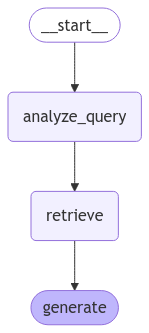

In [32]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
# We can test our implementation by specifically asking for context from the end of the post. Note that the model includes different information in its answer.

for step in graph.stream(
    {"question": "What does the post say about Task?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='43734609-42f1-4ac4-a2e8-25a4f607ce7d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192, 'section': 'beginning'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='7bf4aa58-9359-425a-a19b-faecdd56

In [34]:
all_splits[-1].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 42189,
 'section': 'end'}

In [35]:
res = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='b6521b24-a99f-486a-9d15-74cdcc440ed4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='f42b7d31-334a-4f41-8408-7484566eaf2b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 19372}, page_content="(3) Task ex

In [37]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='a392a121-fc3e-447a-89a9-31c3a4da9c03', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39220, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adj

In [39]:
for step in graph.stream(
    {"question": "Give me the link to “Announcing ScaNN: Efficient Vector Similarity Search” article at the end of the post?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Announcing ScaNN: Efficient Vector Similarity Search', 'section': 'any'}}}

----------------

{'retrieve': {'context': [Document(id='ef848841-03c1-48e8-8230-f6fe51f11222', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 12088, 'section': 'beginning'}, page_content='Maximum Inner Product Search (MIPS)#\nThe external memory can alleviate the restriction of finite attention span.  A standard practice is to save the embedding representation of information into a vector store database that can support fast maximum inner-product search (MIPS). To optimize the retrieval speed, the common choice is the approximate nearest neighbors (ANN)\u200b algorithm to return approximately top k nearest neighbors to trade off a little accuracy lost for a huge speedup.\nA couple common choices of ANN algorithms for fast MIPS:'), Document(id='8fcbaa52-2481-4bea-ac3e-9587ad3c1df4', metadata={'source': 'https://lilianweng.github.

In [40]:
for step in graph.stream(
    {"question": "What are the challenges to Task Decomposition mentioned at the end of the article?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition challenges', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='a392a121-fc3e-447a-89a9-31c3a4da9c03', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39220, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs stru